## Project.7 Машинное обучение в бизнесе

    (yandex_practicum by student@pavel_matushevskiy, Volgograd 2022)


### Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.  

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

#### Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных

Данные геологоразведки трёх регионов находятся в файлах:  

/datasets/geo_data_0.csv  

/datasets/geo_data_1.csv  

/datasets/geo_data_2.csv  

id — уникальный идентификатор скважины;  

f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  

product — объём запасов в скважине (тыс. баррелей).

### Шаг 1-1. Импорт библиотек и настроек

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import RandomState
from sklearn.preprocessing import Normalizer, RobustScaler, MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy import stats as st

RANDOM_STATE = 42

### Шаг 1-2. Загрузка данных и общий обзор.

In [3]:
# Создадим датафреймы:
df1 = pd.read_csv('datasets/geo_data_0.csv')
df2 = pd.read_csv('datasets/geo_data_1.csv')
df3 = pd.read_csv('datasets/geo_data_2.csv')

In [4]:
# Посмотрим на сами данные:
for df in (df1, df2, df3):
    print(df.head())
    print()

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



In [5]:
# Посмотрим информацию по нашим датафреймам:
for df in (df1, df2, df3):
    print(df.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column

In [6]:
# На всякий случай проверим дубликаты:
for df in (df1, df2, df3):
    print("количество дубликатов:", df.duplicated().sum())

количество дубликатов: 0
количество дубликатов: 0
количество дубликатов: 0


### Промежуточный вывод

 1. Все датафреймы содержат одинаковый объём данных.
 2. Пропущенных значений или несоответствия типов нигде нет, явных дубликатов - тоже нет.
 3. Столбец id для предсказаний нам нужно будет исключить, но  не будем удалять, т.к. он может пригодиться нам а будущем для идентификации скважины.
 4. Адекватность значений признаков f0,f1,f2 мы не можем оценить т.к. контекст их нам неизвестен.
Более детально исследуем признаки. 

### Шаг 1-3. Подготовка данных

Из данных нас интересуют признаки 'f0', 'f1', 'f2' в каждом из 3 датасетов.   

Они числовые. Изучим детальней их. 

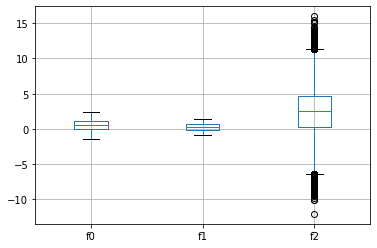

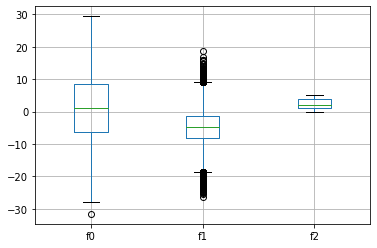

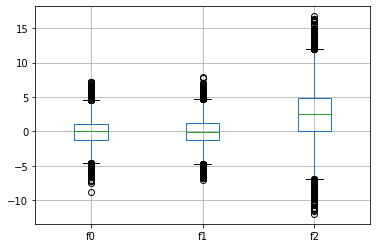

In [7]:
# Построим боксплоты (так мы оценим наличие выбросов): выбросы есть.
for df in [df1, df2, df3]:
    df.boxplot(column=['f0', 'f1', 'f2'])
    plt.show()

### Промежуточный вывод

1. Сами значения внутри фрейма различаются в амплитуде значений (нужно обработать этот факт)
2. Выбросы есть, заменим их используя межквартильный размах по верхней и нижней границе 1.5* перцентиля (значения заменим).

In [8]:
# Удалим выбросы c заменой выбросов на макс и мин значения по границам перцентилей:
for df in [df1, df2, df3]:
    for x in ['f0', 'f1', 'f2']:
        q75, q25 = np.percentile(df.loc[:, x], [75, 25])
        intr_qr = q75 - q25

        max = q75 + (1.5 * intr_qr)
        min = q25 - (1.5 * intr_qr)

        df.loc[df[x] < min, x] = min
        # df.loc[df[x] < min,x] = np.nan #просто удаление выбросов
        df.loc[df[x] > max, x] = max

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Попробовал не обрабатывать выбросы - результаты существенно не изменились. 
</div>

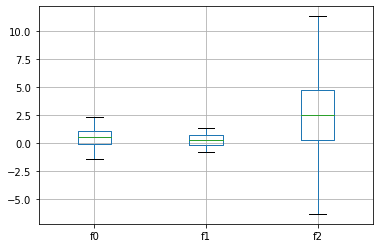

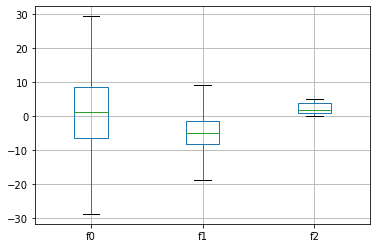

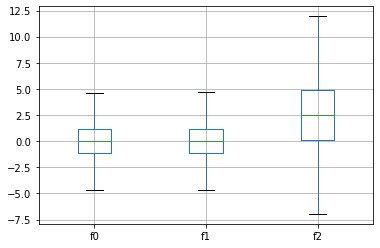

In [9]:
# Проверим результат:
for df in [df1, df2, df3]:
    df.boxplot(['f0', 'f1', 'f2'])
    plt.show()

### Вывод

- Мы ознакомились с нашими данными
- Убедились в отсутствии пропусков, дубликатов
- Избавились от выбросов
- Определились с тем, что признаки нужно будет стандартизировать

### 2. Обучение и проверка модели

In [10]:
# Разобьем выборки в пропорции 75%/25% (согласно тех. заданию)
def split_df(df):
    target = df['product']
    features = df[['f0', 'f1', 'f2']]

    return train_test_split(features,
                            target,
                            test_size=0.25,
                            random_state=RANDOM_STATE)


features_train_1, features_valid_1, target_train_1, target_valid_1 = split_df(
    df1)
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_df(
    df2)
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_df(
    df3)

In [11]:
# Стандартизируем признаки для лучшей обучаемости модели:
def scale_features(features_train, features_valid):
    scaler = StandardScaler()  # best result
    # scaler = RobustScaler () # MaxAbsScaler MinMaxScaler Normalizer RobustScaler

    numeric = ['f0', 'f1', 'f2']
    scaler.fit(features_train[numeric])
    pd.set_option('mode.chained_assignment', None)
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])

    return features_train, features_valid


features_train_1, features_valid_1 = scale_features(features_train_1,
                                                    features_valid_1)
features_train_2, features_valid_2 = scale_features(features_train_2,
                                                    features_valid_2)
features_train_3, features_valid_3 = scale_features(features_train_3,
                                                    features_valid_3)

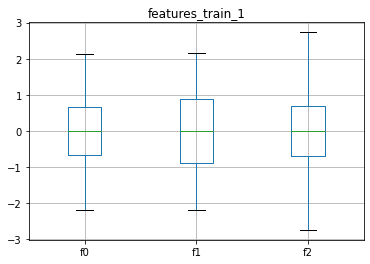

In [12]:
# Проверим что имеем на выходе:
features_train_1.boxplot(['f0', 'f1', 'f2'])
plt.title("features_train_1")
plt.show()

Далее обучим модель и проверим ее на валидационной выборке.  

По тех заданию обучение модели должно проходить на линейной регрессии

In [13]:
# напишем функцию для рассчета метрики rmse
def rmse(target, predicted):
    mse = mean_squared_error(target, predicted)
    return mse**0.5


# для интереса напишем функцию, котора будет выводить все результаты нашей модели (MSE, RMSE, R2)
def full_scores(target, predicted):
    mae = mean_absolute_error(target, predicted)
    mse = mean_squared_error(target, predicted)
    rmse_metric = rmse(target, predicted)
    r2 = r2_score(target, predicted)
    predicted_mean = predicted.mean()

    print('|{: >9}|{: >9}|{: >9}|{: >9}|{: >15}|'.format(
        'MAE', 'MSE', 'RMSE', 'R2', 'Predicted mean'))
    print('|{: >9.6f}|{: >9.4f}|{: >9.7f}|{: >9.6f}|{: >15.6f}|'.format(
        mae, mse, rmse_metric, r2, predicted_mean))

    # по условиям задачи дальше нам интересно сохранять средние предсказанные значения и rmse
    return rmse, predicted_mean


def train_the_model(features_train, target_train, features_valid,
                    target_valid):
    #model = LinearRegression()
    model = linear_model.Lasso(alpha=0.1)
    model = linear_model.Ridge(alpha=.1)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    predicted_mean, rmse = full_scores(target_valid, predicted_valid)

    return predicted_mean, rmse, predicted_valid

In [14]:
# Выведем информацию моделей по каждому датасету:
print('Model for region 1')
predicted_mean_1, rmse_1, predicted_valid_1 = train_the_model(
    features_train_1, target_train_1, features_valid_1, target_valid_1)
predicted_valid_df_1 = pd.Series(
    data=predicted_valid_1, index=target_valid_1.index)
print()
print('Model for region 2')
predicted_mean_2, rmse_2, predicted_valid_2 = train_the_model(
    features_train_2, target_train_2, features_valid_2, target_valid_2)
predicted_valid_df_2 = pd.Series(
    data=predicted_valid_2, index=target_valid_2.index)
print()
print('Model for region 3')
predicted_mean_3, rmse_3, predicted_valid_3 = train_the_model(
    features_train_3, target_train_3, features_valid_3, target_valid_3)
predicted_valid_df_3 = pd.Series(
    data=predicted_valid_3, index=target_valid_3.index)

Model for region 1
|      MAE|      MSE|     RMSE|       R2| Predicted mean|
|31.027226|1424.4707|37.7421614| 0.273385|      92.402557|

Model for region 2
|      MAE|      MSE|     RMSE|       R2| Predicted mean|
| 0.717022|   0.7926|0.8902872| 0.999625|      68.712911|

Model for region 3
|      MAE|      MSE|     RMSE|       R2| Predicted mean|
|32.879556|1610.7939|40.1346973| 0.196794|      94.769665|


### Промежуточный вывод

    1. Что любопытно, RMSE модели для 1го и 3го региона очень похожи, как и предсказанные значения, однако сами значения имеют довольно приличное отклонение
    2. В то же время, для второго региона мы имеем гораздо лучшую точность, но и меньшее предсказание средних запасов

### 3. Подготовка к расчёту прибыли

In [15]:
# Внесем основные параметры задачи
count_points_explore = 500  # количество точек нужно исследовать для  разведки региона
# количество точек для расчета прибыли (лучшие точки)
count_points_profit = 200
project_budget = 10 * (10 ** 9)  # бюджет на разработку (в рублях)
barrel_profit = 450  # стоимость одного барреля (в рублях)
product_profit = barrel_profit * 1000  # стоимость единицы продукта (в рублях)
# предельная вероятность убытков на регион (в процентах) - по тех. заданию
loss_limit = 2.5

In [16]:
# Рассчитаем достаточный объём сырья для безубыточной разработки (региона)
product_per_region_min = project_budget / product_profit
print("минимальный объём сырья для безубыточной разработки:",
      round(product_per_region_min, 2))

минимальный объём сырья для безубыточной разработки: 22222.22


In [17]:
# Рассчитаем то же самое для скважины
product_per_point_min = product_per_region_min / count_points_profit
print("минимальный объём сырья для безубыточной разработки 1 скважины:",
      round(product_per_point_min, 2))

минимальный объём сырья для безубыточной разработки 1 скважины: 111.11


In [18]:
# Напишем функцию рассчета прибыли
def calculate_profit(target, probabilities):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count_points_profit]
    return selected.sum() * product_profit - project_budget

In [19]:
# Посчитаем профит по каждому региону
print('Профит для 1 региона согласно модели, руб.:', round(
    calculate_profit(target_valid_1, predicted_valid_df_1), 2))
print('Профит для 2 региона согласно модели, руб.:', round(
    calculate_profit(target_valid_2, predicted_valid_df_2), 2))
print('Профит для 3 региона согласно модели, руб.:', round(
    calculate_profit(target_valid_3, predicted_valid_df_3), 2))

Профит для 1 региона согласно модели, руб.: 3459271008.58
Профит для 2 региона согласно модели, руб.: 2415086696.68
Профит для 3 региона согласно модели, руб.: 2598571759.37


### Промежуточный вывод

1. В нашем случае, для разработки в ноль необходимо чтобы каждая скважина из 200, по которым рассчитывается прибыль, добывала минимум 111 едниц продукта.
2. При этом средние значения, которые мы предсказали для всех регионов меньше данного значения.
3. Однако, несмотря на это в каждом регионе мы имеем положительную прибыль от разработки.

### 4. Расчёт прибыли и рисков 

С помощью бутстрапа найдем распределение прибыли

In [20]:
#  функцию для наших вычислений бутстрепа
def make_bootstrap(target, probabilities):
    state = np.random.RandomState(42)

    values = []
    for i in range(1000):
        target_subsample = target.sample(n=count_points_explore,
                                         replace=True,
                                         random_state=state)
        probs_subsample = probabilities[target_subsample.index]

        values.append(calculate_profit(target_subsample, probs_subsample))

    values = pd.Series(values)

    alpha = 0.95
    df = values.count() - 1
    confidence_interval_mean = st.t.interval(alpha,
                                             df,
                                             loc=values.mean(),
                                             scale=values.sem())
    lower = values.quantile(0.01)

    mean = round(values.mean(), 2)
    print("Средняя прибыль:", mean, "руб.")
    print("95% доверительный интервал (истинное среднее)",
          confidence_interval_mean)
    confidence_interval_pred = (values.quantile(0.025), values.quantile(0.975))
    print("95% доверительный интервал (прогноз)", confidence_interval_pred)

    loss_probability = values[values < 0].count() / values.count()
    print('Вероятность убытка = {:.2%}'.format(loss_probability))

    if loss_probability < loss_limit / 100:
        print('Регион годится для разработки')

    print()

In [21]:
print('Model for region 1')
make_bootstrap(target_valid_1, predicted_valid_df_1)
print('Model for region 2')
make_bootstrap(target_valid_2, predicted_valid_df_2)
print('Model for region 3')
make_bootstrap(target_valid_3, predicted_valid_df_3)

Model for region 1
Средняя прибыль: 427825835.9 руб.
95% доверительный интервал (истинное среднее) (411053455.7655068, 444598216.031941)
95% доверительный интервал (прогноз) (-97249829.56859533, 947654212.5971403)
Вероятность убытка = 5.50%

Model for region 2
Средняя прибыль: 511362776.2 руб.
95% доверительный интервал (истинное среднее) (497955918.3541165, 524769634.04125386)
95% доверительный интервал (прогноз) (98870649.90277724, 940720511.6508039)
Вероятность убытка = 0.90%
Регион годится для разработки

Model for region 3
Средняя прибыль: 402750614.47 руб.
95% доверительный интервал (истинное среднее) (385676282.7460525, 419824946.1896508)
95% доверительный интервал (прогноз) (-137162225.07193202, 929887528.0253205)
Вероятность убытка = 7.40%



### Промежуточный вывод

В нашем случае нам даже не пришлось выбирать, т.к. регион, в котором с 95% вероятностью прибыть превысит 511 миллиона и самой низкой вероятностью убытков - второй. Именно этот регион и следует выбрать для разработки.

### Общий вывод

1. Мы изучили данные и избавились от выбросов, чтобы более точно обучить нашу модель
2. Мы стандартизировали наши признаки, чтобы они оказывали сопоставимое влияние на обучение нашей модели
3. В дальнейшем мы обучили нашу модель и получили предварительные оценки самой модели и наших трех регионов
     - второй регион показал худший средний результат и отличную точность
     - первый и второй оказались очень похожими друг на друга
4. Мы рассчитали прибыльность каждого региона по предсказанным данным (каждый регион оказался прибыльным)
5. Однако, поскольку для оценки региона этого было недостаточно, мы применили бутстрап, чтобы оценить регион с разных точек и получить средние значения генеральной совокупности
    
    Изучив эти данные, мы можем однозначно сказать, что разрабатывать имеет смысл именно второй регион, т.к. он одновременно обеспечивает самую высокую среднюю прибыль (выше 511 миллионов) при минимальном риске в 0.9 процент
    